In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义自定义 Transformer 模型
class CustomTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super(CustomTransformer, self).__init__()
        
        # 词嵌入层
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 500, embed_dim))  # 固定长度的Positional Encoding
        
        # Transformer编码器
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 分类器
        self.classifier = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        # 输入: (batch_size, seq_len)
        embedded = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        
        # 转置为 (seq_len, batch_size, embed_dim) 以匹配Transformer输入格式
        embedded = embedded.permute(1, 0, 2)
        
        # Transformer 编码器
        encoded = self.encoder(embedded)  # 输出: (seq_len, batch_size, embed_dim)
        
        # 提取序列第一个位置的表示用于分类
        output = self.classifier(encoded[0, :, :])  # 取第一个时间步
        
        return output

In [12]:
# 超参数
input_dim = 20000  # 假设有 20000 个不同的词
embed_dim = 128    # 嵌入维度
num_heads = 4      # 注意力头数
num_layers = 2     # 编码器层数
num_classes = 2    # 假设有 2 个类别
dropout = 0.1      # Dropout 概率

# 初始化模型
model = CustomTransformer(input_dim, embed_dim, num_heads, num_layers, num_classes, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


D:\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CustomTransformer(
  (embedding): Embedding(20000, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [4]:
pip install transformers

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
     --------------- ------------------------ 3.9/10.1 MB 26.0 MB/s eta 0:00:01
     --------------------------------------- 10.1/10.1 MB 39.5 MB/s eta 0:00:00
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/44/69/d21eb253fa91622da25585d362a874fa4710be600f0ea9446d8d0217cec1/tokenizers-0.21.0-cp39-abi3-win_amd64.whl (2.4 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/6d/41/948c96c8a7e9fef57c2e051f1871c108a6dbbc6d285598bdb1d89b98617c/safetensors-0.4.5-cp311-none-win_amd64.whl (285 kB)
Note: you may need to restart the kernel to use updated packages.


In [13]:
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer

# 使用 BertTokenizer 进行分词
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 示例文本
texts = ["深度学习是计算机的前沿技术", "糖尿病患者通常含有较低的胰岛素"]
labels = [0, 1]  # 假设有两个类别

# 将文本转为 token ID，并进行填充
inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# 转换为 TensorDataset
labels = torch.tensor(labels)
dataset = TensorDataset(input_ids, labels)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# 定义训练函数并记录损失
def train_with_loss_curve(model, dataloader, optimizer, criterion, device, epochs):
    train_losses = []  # 保存每个 epoch 的平均损失

    for epoch in range(epochs):
        model.train()  # 切换到训练模式
        total_loss = 0  # 累加所有 batch 的损失

        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in tqdm(dataloader, desc="Training"):
            input_ids, labels = [b.to(device) for b in batch]  # 将数据迁移到设备上
            
            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(input_ids)
            loss = criterion(outputs, labels)  # 计算损失
            total_loss += loss.item()  # 累加当前 batch 的损失
            
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        
        # 计算当前 epoch 的平均损失
        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1} Loss: {avg_loss:.4f}")
    
    return train_losses



In [16]:
def plot_loss_curve(train_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()


Epoch 1/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 1 Loss: 0.6268
Epoch 2/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 2 Loss: 1.1205
Epoch 3/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 3 Loss: 0.4297
Epoch 4/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 4 Loss: 0.3070
Epoch 5/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 5 Loss: 0.1207
Epoch 6/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 6 Loss: 0.1143
Epoch 7/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 7 Loss: 0.0415
Epoch 8/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 8 Loss: 0.0167
Epoch 9/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 9 Loss: 0.0040
Epoch 10/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 10 Loss: 0.0017


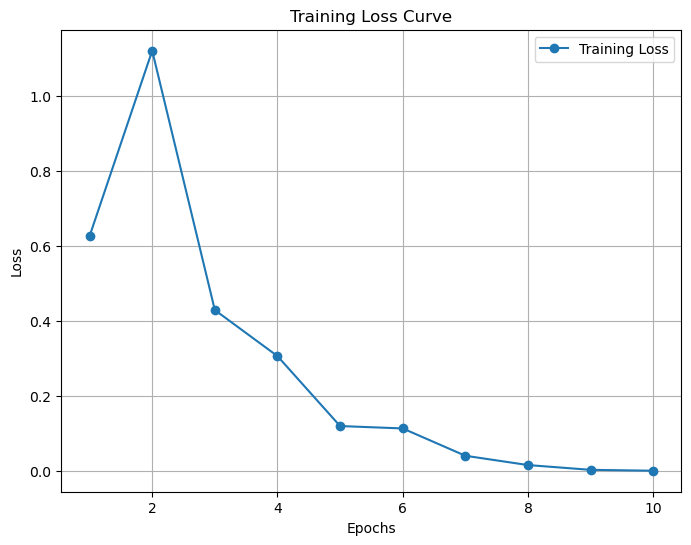

In [17]:
# 定义超参数
epochs = 10  # 训练轮数
learning_rate = 1e-3  # 学习率

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


# 调用训练函数
train_losses = train_with_loss_curve(model, dataloader, optimizer, criterion, device, epochs)

# 绘制损失曲线
plot_loss_curve(train_losses)



In [18]:
def predict_text(text, model, tokenizer, device):
    """
    对单条文本进行分类预测
    """
    model.eval()  # 设置为评估模式

    # 对输入文本进行分词和编码
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # 将数据迁移到模型所在的设备

    with torch.no_grad():  # 禁用梯度计算
        outputs = model(inputs['input_ids'])  # 前向传播
        predicted_label = torch.argmax(outputs, dim=1).item()  # 获取预测结果

    return predicted_label  # 返回预测的类别索引


In [22]:
# 建立类别名称与索引的映射
label_to_category = {
    0: "计算机",
    1: "医学"
}

In [23]:
# 示例文本
text = "决策树是一种常见的机器学习模型"  

# 调用预测函数
predicted_label = predict_text(text, model, tokenizer, device)
print(f"Predicted Label: {predicted_label}")


Predicted Label: 0


In [24]:
print(f"Predicted Category: {label_to_category[predicted_label]}")

Predicted Category: 计算机


In [27]:
# 示例文本
text = "糖尿病分为A型和B型"  

# 调用预测函数
predicted_label = predict_text(text, model, tokenizer, device)
print(f"Predicted Label: {predicted_label}")

Predicted Label: 1


In [28]:
print(f"Predicted Category: {label_to_category[predicted_label]}")

Predicted Category: 医学


In [39]:
# 定义自定义 Transformer 模型
class CustomTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super(CustomTransformer, self).__init__()
        
        # 词嵌入层
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 500, embed_dim))  # 固定长度的 Positional Encoding
        
        # Transformer编码器
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # 分类器
        self.classifier = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x, return_attention=False):
        """
        自定义前向传播
        :param x: 输入序列 (batch_size, seq_len)
        :param return_attention: 是否返回注意力权重
        """
        # 嵌入
        embedded = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        embedded = embedded.permute(1, 0, 2)  # 转置为 (seq_len, batch_size, embed_dim)
        
        # 初始化注意力权重列表
        attn_weights_list = []
        
        # Transformer 编码器
        for layer in self.encoder_layers:
            if return_attention:
                encoded, attn_weights = layer.self_attn(embedded, embedded, embedded, need_weights=True)
                attn_weights_list.append(attn_weights)  # 收集当前层的注意力权重
            else:
                encoded = layer(embedded)
            embedded = encoded  # 更新输入
        
        # 分类器输出
        output = self.classifier(encoded[0, :, :])  # 取第一个时间步的嵌入
        
        if return_attention:
            # 返回分类结果和注意力权重
            return output, torch.stack(attn_weights_list, dim=0)  # (num_layers, num_heads, seq_len, seq_len)
        return output


In [40]:
# 模型参数
input_dim = 20000  # 假设有 20000 个不同的词
embed_dim = 128    # 嵌入维度
num_heads = 4      # 注意力头数
num_layers = 2     # 编码器层数
num_classes = 2    # 假设有 2 个类别
dropout = 0.1      # Dropout 概率

# 初始化模型
model = CustomTransformer(input_dim, embed_dim, num_heads, num_layers, num_classes, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CustomTransformer(
  (embedding): Embedding(20000, 128)
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [42]:
# 定义训练函数
def train_model(model, dataloader, optimizer, criterion, device, epochs):
    model.train()  # 切换到训练模式

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids, labels = [b.to(device) for b in batch]  # 将数据迁移到设备上

            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(input_ids)
            loss = criterion(outputs, labels)  # 计算损失
            total_loss += loss.item()
            
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")

# 超参数
epochs = 10
learning_rate = 1e-3

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 调用训练函数
train_model(model, dataloader, optimizer, criterion, device, epochs)



Epoch 1/10


Training Epoch 1/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 1 - Loss: 0.1429
Epoch 2/10


Training Epoch 2/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch 2 - Loss: 0.1406
Epoch 3/10


Training Epoch 3/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 3 - Loss: 0.0025
Epoch 4/10


Training Epoch 4/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch 4 - Loss: 0.0010
Epoch 5/10


Training Epoch 5/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 5 - Loss: 0.0005
Epoch 6/10


Training Epoch 6/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 6 - Loss: 0.0006
Epoch 7/10


Training Epoch 7/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 7 - Loss: 0.0002
Epoch 8/10


Training Epoch 8/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 8 - Loss: 0.0003
Epoch 9/10


Training Epoch 9/10: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 9 - Loss: 0.0002
Epoch 10/10


Training Epoch 10/10: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

Epoch 10 - Loss: 0.0001


D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWa

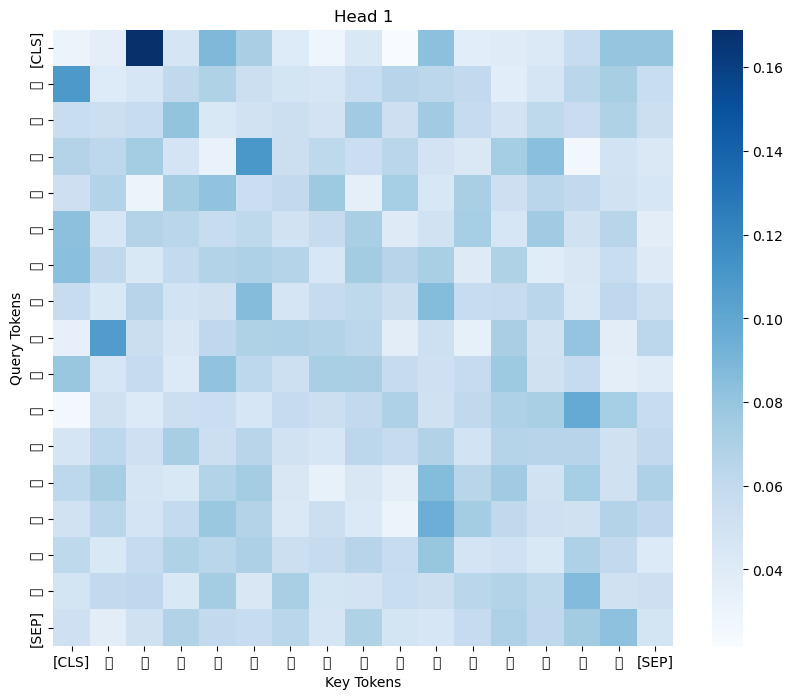

D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWa

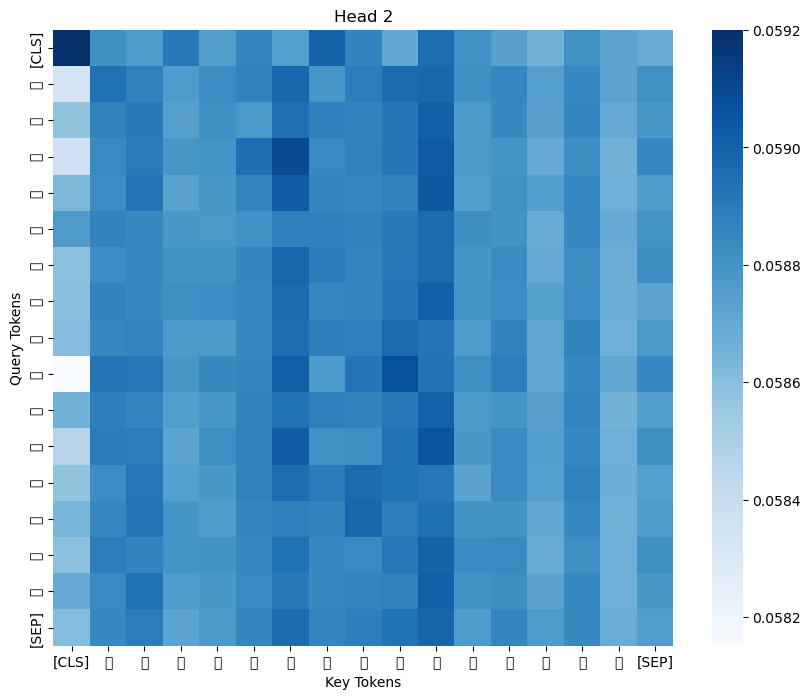

In [49]:
def get_attention_and_visualize(text, model, tokenizer, device):
    """
    获取文本的注意力权重并可视化
    :param text: 输入文本
    :param model: 训练好的 Transformer 模型
    :param tokenizer: 分词器
    :param device: 设备
    """
    model.eval()

    # 对文本进行分词
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)

    with torch.no_grad():
        # 获取分类结果和注意力权重
        outputs, attn_weights = model(input_ids, return_attention=True)

    # 将注意力权重的维度调整为 (num_layers, num_heads, seq_len, seq_len)
    attn_weights = attn_weights.squeeze(1)  # 去掉 batch_size 维度
    input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

    # 可视化注意力权重
    visualize_attention_weights(attn_weights, input_tokens)
    


# 可视化函数
def visualize_attention_weights(attn_weights, input_tokens):
    """
    可视化注意力权重
    :param attn_weights: 注意力权重 (num_heads, seq_len, seq_len)
    :param input_tokens: 输入序列的 token 列表
    """
    num_heads = attn_weights.shape[0]  # 注意力头数
    seq_len = len(input_tokens)  # 序列长度

    for head in range(num_heads):
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            attn_weights[head].cpu().detach().numpy(),
            xticklabels=input_tokens,
            yticklabels=input_tokens,
            cmap="Blues"
        )
        plt.title(f"Head {head + 1}")
        plt.xlabel("Key Tokens")
        plt.ylabel("Query Tokens")
        plt.show()


# 示例文本
text = "决策树是一种常见的机器学习模型"
get_attention_and_visualize(text, model, tokenizer, device)

